# Your name:

# Starter Code

This notebook implements starter code to help you get started with the assignment. If you have a personal GPU, copy this starter code to another directory and run this notebook using your personal GPU. In that case, the docker we provide will not support PyTorch with GPU, and you can create your own virtual environment (e.g., conda) with PyTorch support (https://pytorch.org/get-started/locally/). 

To run this notebook you must __first create a folder called `./dataset` and download all the data files from the Kaggle competition page__.

In [492]:
import time
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
%matplotlib inline

log_interval = 1000,
epochs = 1

params = {
    'log_interval': 1000,
    'epochs': 1
}

In [493]:
# GPU setup
use_cuda = torch.cuda.is_available()
print("Using {}".format('GPU' if use_cuda else 'CPU'))

Using GPU


In [494]:
# Abstract a "one-of-N" or N-way one-hot decision (usually for assigning a factor of a rank to a memory level)
#
# Initialization:
# - num_factors: number of decision ways (factors) to choose between
#
# Input: 
# - x: [factors, baselines, temperature]
# - factors is a list length num_factors containing the factors to select among
# - baselines is a list of length num_factors containing the way-wise value that 
#   an output way should have when it is unselected
# - temperature is a software parameter; high temperature smooths the softmax, 
#   low temperature approximates a discrete decision
#
# Trainable parameters:
# - W: way-wise weights input to softmax
#
# Output: tensor of num_factors outputs. The way i which is weighted highest in W 
#         should be railed to factors[i], the other ways should be weighted to baselines[i]

import torch.nn as nn

class FactorMux(nn.Module):
    def __init__(self, num_factors):
        super(FactorMux, self).__init__()
        self.num_factors = num_factors
        self.W = torch.nn.Parameter(torch.randn(self.num_factors))
        self.W.requires_grad = True
        self.softmax1 = nn.Softmax()

    def forward(self, x):
        # x: [factors, baselines, temperature]
        
        assert len(x) == 2*self.num_factors + 1
        
        factors = x[0:self.num_factors]
        baselines = x[self.num_factors:(2*self.num_factors)]
        temperature = x[2*self.num_factors].item()
        
        #print(factors, baselines, 1.0/temperature)
        
        x = self.softmax1((1.0/temperature)*self.W) * (factors - baselines) + baselines
        
        return x


fmux = FactorMux(2)

#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [495]:
# Test FactorMux
fmux.W.data = torch.tensor([1, 0])
fmux(torch.tensor([2.0, 2.0, 1.0, 1.0, 0.01]))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([2., 1.], grad_fn=<AddBackward0>)

In [496]:
import torch.nn as nn

class LoopNestSelector(FactorMux):
    def __init__(self, num_datatypes):
        super(LoopNestSelector, self).__init__(num_datatypes) # FactorMux num_factors
        self.baseline = 1.0

    def forward(self, x):
        # x: [factors, temperature]

        if not torch.is_tensor(x):
            x = torch.tensor(x)
        
        reuse_factors = x[0:self.num_factors]
        temperature = torch.tensor([x[self.num_factors].item()])
        
        #print(reuse_factors, reuse_factors*0.0 + self.baseline, temperature)
        
        inputs = torch.cat((reuse_factors, reuse_factors*0.0 + self.baseline, temperature), 0)
        x = super().forward(inputs)
        
        return x

In [497]:
rmux = LoopNestSelector(3)
rmux.W.data = torch.tensor([0.0,0.1,0.0])
rmux([3, 4, 5, 0.001])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([1., 4., 1.], grad_fn=<AddBackward0>)

In [498]:
import torch.nn as nn

class RankLoopBoundSelector(nn.Module):
    def __init__(self, num_rank_loops, rank_factor_list):
        super(RankLoopBoundSelector, self).__init__() # FactorMux
            
        if not torch.is_tensor(rank_factor_list):
            rank_factor_list = torch.tensor(rank_factor_list)            
        
        self.num_rank_loops = num_rank_loops
        self.rank_factor_list = rank_factor_list
        self.num_rank_factors = len(self.rank_factor_list)
        self.factorMuxes = nn.ModuleList([FactorMux(self.num_rank_loops) for factor in self.rank_factor_list])
        
        self.baseline = 1.0

    def forward(self, x):
        # x: [temperature]

        if not torch.is_tensor(x):
            x = torch.tensor([x])
        
        x = torch.stack( \
            [self.factorMuxes[mdx](
            torch.cat( \
            (torch.full((self.num_rank_loops,), self.rank_factor_list[mdx]), torch.full((self.num_rank_loops,), self.baseline), \
            x),0) \
            ) \
            for mdx in range(self.num_rank_factors)])
        
        x = torch.prod(x,0)
        
        #print(x)
        
        #x = torch.tensor([  for vec in x])
        
        return x

In [499]:
rlbs = RankLoopBoundSelector(3, [3, 2, 5])

In [500]:
print(rlbs(0.0001))

tensor([10.,  3.,  1.], grad_fn=<ProdBackward1>)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [501]:
list(rlbs.parameters())

[Parameter containing:
 tensor([ 0.4519,  1.5944, -0.8727], requires_grad=True), Parameter containing:
 tensor([-0.8233, -1.8675, -1.6099], requires_grad=True), Parameter containing:
 tensor([ 1.9083,  0.6641, -0.5992], requires_grad=True)]

In [502]:
import math



primes(244)

[2, 2, 61]

In [503]:
math.log(86,2)

6.426264754702098

In [504]:
import torch.nn as nn

class MapSelector_spGEMM(nn.Module):
    
    def repeat_prime(self, n, d):
        lst = [d]
        fac = d

        while n % (fac * d) == 0:
            fac = fac * d
            lst.append(d)

        return lst

    # https://stackoverflow.com/questions/16996217/prime-factorization-list
    def primes(self, n):
        divisors = [ self.repeat_prime(n, d) for d in range(2,n//2+1) if n % d == 0 ]
        divisors = sum(divisors, [])
        return [ d for d in divisors if \
                 all( d % od != 0 for od in divisors if od != d ) ]    
    
    def __init__(self, M, K, N):
        super(MapSelector_spGEMM, self).__init__() # FactorMux
        
        self.M = M
        self.K = K
        self.N = N
        self.M_factors = self.primes(self.M)
        self.K_factors = self.primes(self.K)
        self.N_factors = self.primes(self.N)
        self.main_mem_loops = 2
        self.local_mem_loops = 1
        self.total_loops = self.main_mem_loops + self.local_mem_loops
        
        # Loop bounds
        self.M_bound_selector = RankLoopBoundSelector(self.total_loops, self.M_factors)
        self.K_bound_selector = RankLoopBoundSelector(self.total_loops, self.K_factors)
        self.N_bound_selector = RankLoopBoundSelector(self.total_loops, self.N_factors)        
        
        # Loop nest ordering
        self.num_datatypes = 3
        self.main_mem_temporal_LoopNestSelector = LoopNestSelector(self.num_datatypes)        

    def forward(self, x):
        # x: [temperature]

        if not torch.is_tensor(x):
            x = torch.tensor([x])
        
        # Calculate loop bounds
        M_loop_bounds = self.M_bound_selector(x)
        K_loop_bounds = self.K_bound_selector(x)
        N_loop_bounds = self.N_bound_selector(x)        
        M_main_mem_temporal = M_loop_bounds[1][None] # B reuse ceiling
        K_main_mem_temporal = K_loop_bounds[1][None] # Z reuse ceiling
        N_main_mem_temporal = N_loop_bounds[1][None] # A reuse ceiling
        
        #print(torch.flatten(torch.cat((N_main_mem_temporal, M_main_mem_temporal, K_main_mem_temporal, x),0)))
        
        # Calculate loop nest ordering
        main_mem_loop_nest = self.main_mem_temporal_LoopNestSelector( \
            torch.flatten(torch.cat((N_main_mem_temporal, M_main_mem_temporal, K_main_mem_temporal, x),0)))
        
        #print(M_loop_bounds,K_loop_bounds,N_loop_bounds, main_mem_loop_nest)        
        
        x = torch.cat((M_loop_bounds,K_loop_bounds,N_loop_bounds, main_mem_loop_nest),0)
        
        # torch.tensor([L1 spatial bound & L1 temporal bound & L0 temporal bound For ranks M, K, N; reuse factor for A, B, Z])
        return x

In [505]:
MSs = MapSelector_spGEMM(2*3, 5*5, 3*7)
MSs(0.00001)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([1., 3., 2., 5., 5., 1., 1., 7., 3., 1., 3., 1.], grad_fn=<CatBackward>)

In [613]:
net.calcMap(1.0)

tensor([ 3.,  1.,  4.,  3.,  1.,  5., 35.,  1.,  1.,  1.,  1.,  1.],
       grad_fn=<CatBackward>)

In [641]:
list(list(net.named_children())[0][1].named_children())[3][1](torch.tensor([2,2,2,0.0001]))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([2., 1., 1.], grad_fn=<AddBackward0>)

In [611]:
list(net.parameters())

[Parameter containing:
 tensor([-1.2506,  0.5754,  1.9506], requires_grad=True), Parameter containing:
 tensor([0.0230, 0.0995, 2.2719], requires_grad=True), Parameter containing:
 tensor([ 0.3401,  0.1958, -0.2907], requires_grad=True), Parameter containing:
 tensor([ 1.7408, -1.7152, -0.9421], requires_grad=True), Parameter containing:
 tensor([0.6512, 0.2699, 1.4484], requires_grad=True), Parameter containing:
 tensor([-0.2385, -1.4325, -2.4605], requires_grad=True), Parameter containing:
 tensor([-0.2442, -0.2462, -0.5304], requires_grad=True), Parameter containing:
 tensor([2.0660, 1.8921, 1.9983], requires_grad=True)]

In [580]:
import torch.nn as nn
import numpy as np

class ArchMap_spGEMM(nn.Module): 
    
    def __init__(self, M, K, N):
        super(ArchMap_spGEMM, self).__init__() # FactorMux
        
        self.M = M
        self.K = K
        self.N = N
        self.mapper = MapSelector_spGEMM(M, K, N)

    def forward(self, x):
        # x: [temperature]

        if not torch.is_tensor(x):
            x = torch.tensor([x])
        
        # Problem characteristics
        M = float(self.M)
        K = float(self.K)
        N = float(self.N)
        A_matrix_size = M*K
        B_matrix_size = K*N
        Z_matrix_size = M*N
        main_memory_size = A_matrix_size+B_matrix_size+Z_matrix_size
        total_num_macs = M*K*N
        
        T = x
        
        # Calculate map (loop bounds & loop nest)
        # torch.tensor([L1 spatial bound & L1 temporal bound & L0 temporal bound For ranks M, K, N; reuse factor for A, B, Z])
        x = self.mapper(x)
        
        self.x = x
        
        # Break out map parameters
        M_L1_spatial_bound = x[0]
        M_L1_temporal_bound = x[1]
        M_L0_temporal_bound = x[2]
        K_L1_spatial_bound = x[3]
        K_L1_temporal_bound = x[4]
        K_L0_temporal_bound = x[5]
        N_L1_spatial_bound = x[6]
        N_L1_temporal_bound = x[7]
        N_L0_temporal_bound = x[8]        
        A_reuse = x[9]
        B_reuse = x[10]
        Z_reuse = x[11]

        # Hook
        self.M_L1_spatial_bound = M_L1_spatial_bound
        self.M_L1_temporal_bound = M_L1_temporal_bound
        self.M_L0_temporal_bound = M_L0_temporal_bound
        self.K_L1_spatial_bound = K_L1_spatial_bound
        self.K_L1_temporal_bound = K_L1_temporal_bound
        self.K_L0_temporal_bound = K_L0_temporal_bound
        self.N_L1_spatial_bound = N_L1_spatial_bound
        self.N_L1_temporal_bound = N_L1_temporal_bound
        self.N_L0_temporal_bound = N_L0_temporal_bound       
        self.A_reuse = A_reuse
        self.B_reuse = B_reuse
        self.Z_reuse = Z_reuse 
        
        # Spatial characteristics
        spatial_fan_out = M_L1_spatial_bound*K_L1_spatial_bound*N_L1_spatial_bound
        
        # Tiling
        main_memory_tile_pair_count = M*K*N/M_L0_temporal_bound/K_L0_temporal_bound/N_L0_temporal_bound
        A_tile_size = M_L0_temporal_bound*K_L0_temporal_bound
        B_tile_size = K_L0_temporal_bound*N_L0_temporal_bound
        Z_tile_size = M_L0_temporal_bound*N_L0_temporal_bound 
        local_memory_num_macs_per_tile = M_L0_temporal_bound*K_L0_temporal_bound*N_L0_temporal_bound
        
        # Per-PE characteristics
        local_memory_size = A_tile_size + B_tile_size + Z_tile_size
        local_num_macs = M*K*N/spatial_fan_out
        
        # Global characteristics
        total_local_memory_size = local_memory_size*spatial_fan_out
        
        # Access counts
        main_memory_reads = main_memory_tile_pair_count*(A_tile_size/A_reuse + B_tile_size/B_reuse + Z_tile_size/Z_reuse)
        main_memory_writes = main_memory_tile_pair_count*(Z_tile_size/Z_reuse)
        local_memory_reads = local_num_macs*3 # A, B, Z
        local_memory_writes = local_num_macs # Just Z
        total_local_memory_reads = local_memory_reads * spatial_fan_out
        total_local_memory_writes = local_memory_writes * spatial_fan_out
        
        # Energy constants (currently arbitrary)
        E_DRAM_static = 0.05
        E_SRAM_static = 0.02
        E_DRAM_acc = 1.0
        E_SRAM_acc = 0.7
        E_MAC = 0.1
        
        # Scale energy consumption of memories to memory size
        main_memory_unit_read_energy = E_DRAM_acc*main_memory_size
        main_memory_unit_write_energy = main_memory_unit_read_energy
        local_memory_static_energy = E_SRAM_static*local_memory_size
        local_memory_unit_read_energy = E_SRAM_acc*local_memory_size
        local_memory_unit_write_energy = local_memory_unit_read_energy
        
        # Calculate energy consumption
        total_main_memory_access_energy = main_memory_reads*main_memory_unit_read_energy + \
                                          main_memory_writes*main_memory_unit_write_energy
        total_local_memory_static_energy = local_memory_static_energy*spatial_fan_out
        total_local_memory_access_energy = total_local_memory_reads*local_memory_unit_read_energy + \
                                           total_local_memory_writes*local_memory_unit_write_energy
        total_MAC_energy = total_num_macs*E_MAC
        total_problem_energy = total_MAC_energy + total_local_memory_access_energy + \
                               total_local_memory_static_energy + total_main_memory_access_energy
        
        # Calculate latency in cycles
        total_problem_latency = local_num_macs
        
        problem_edp = total_problem_energy*total_problem_latency
        
        self.problem_edp = problem_edp
        # Calculate EDP
        if spatial_fan_out.item() > 512.0:

            problem_edp = problem_edp + 1.0e10*((spatial_fan_out - 512.0)/T.item())   
            #print(1.0e20*((spatial_fan_out - 512.0)))
#            problem_edp = total_problem_energy*total_problem_latency + torch.exp((spatial_fan_out - 512.0))
#            print("Being used: ", torch.exp((spatial_fan_out - 512.0)), \
#                   "delta: ", spatial_fan_out - 512.0, \
#                   "spatial fan-out: ", spatial_fan_out)

            #            problem_edp = total_problem_energy*total_problem_latency + torch.exp(-(spatial_fan_out.item() - 512.0)/T.item())
            
            #1.0e10/(1+math.exp(-(spatial_fan_out.item() - 512.0)/T.item()))

        
        return problem_edp
    
    def calcMap(self,x):
        return self.x
    
    def archMapStats(self):
        # Problem characteristics
        M = float(self.M)
        K = float(self.K)
        N = float(self.N)
        A_matrix_size = M*K
        B_matrix_size = K*N
        Z_matrix_size = M*N
        main_memory_size = A_matrix_size+B_matrix_size+Z_matrix_size
        total_num_macs = M*K*N        
        
        x = self.calcMap(1.0)
        
        M_L1_spatial_bound = x[0]
        M_L1_temporal_bound = x[1]
        M_L0_temporal_bound = x[2]
        K_L1_spatial_bound = x[3]
        K_L1_temporal_bound = x[4]
        K_L0_temporal_bound = x[5]
        N_L1_spatial_bound = x[6]
        N_L1_temporal_bound = x[7]
        N_L0_temporal_bound = x[8]        
        A_reuse = x[9]
        B_reuse = x[10]
        Z_reuse = x[11]  
        
        # Spatial characteristics
        spatial_fan_out = M_L1_spatial_bound*K_L1_spatial_bound*N_L1_spatial_bound
        
        # Tiling
        main_memory_tile_pair_count = M*K*N/M_L0_temporal_bound/K_L0_temporal_bound/N_L0_temporal_bound
        A_tile_size = M_L0_temporal_bound*K_L0_temporal_bound
        B_tile_size = K_L0_temporal_bound*N_L0_temporal_bound
        Z_tile_size = M_L0_temporal_bound*N_L0_temporal_bound 
        local_memory_num_macs_per_tile = M_L0_temporal_bound*K_L0_temporal_bound*N_L0_temporal_bound
        
        # Per-PE characteristics
        local_memory_size = A_tile_size + B_tile_size + Z_tile_size
        local_num_macs = M*K*N/spatial_fan_out
        
        print("Spatial fan-out: ", spatial_fan_out.item())
        print("Local memory size: ", local_memory_size.item())
        print("A tile size: ", A_tile_size.item(), "B tile size: ", B_tile_size.item(), "Z tile size: ", Z_tile_size.item())
        
        # Global characteristics
        total_local_memory_size = local_memory_size*spatial_fan_out
        
        # Access counts
        main_memory_reads = main_memory_tile_pair_count*(A_tile_size/A_reuse + B_tile_size/B_reuse + Z_tile_size/Z_reuse)
        main_memory_writes = main_memory_tile_pair_count*(Z_tile_size/Z_reuse)
        local_memory_reads = local_num_macs*3 # A, B, Z
        local_memory_writes = local_num_macs # Just Z
        total_local_memory_reads = local_memory_reads * spatial_fan_out
        total_local_memory_writes = local_memory_writes * spatial_fan_out
        
        # Energy constants (currently arbitrary)
        E_DRAM_static = 0.05
        E_SRAM_static = 0.02
        E_DRAM_acc = 1.0
        E_SRAM_acc = 0.7
        E_MAC = 0.1
        
        # Scale energy consumption of memories to memory size
        main_memory_unit_read_energy = E_DRAM_acc*main_memory_size
        main_memory_unit_write_energy = main_memory_unit_read_energy
        local_memory_static_energy = E_SRAM_static*local_memory_size
        local_memory_unit_read_energy = E_SRAM_acc*local_memory_size
        local_memory_unit_write_energy = local_memory_unit_read_energy
        
        # Calculate energy consumption
        total_main_memory_access_energy = main_memory_reads*main_memory_unit_read_energy + \
                                          main_memory_writes*main_memory_unit_write_energy
        total_local_memory_static_energy = local_memory_static_energy*spatial_fan_out
        total_local_memory_access_energy = total_local_memory_reads*local_memory_unit_read_energy + \
                                           total_local_memory_writes*local_memory_unit_write_energy
        total_MAC_energy = total_num_macs*E_MAC
        total_problem_energy = total_MAC_energy + total_local_memory_access_energy + \
                               total_local_memory_static_energy + total_main_memory_access_energy
        
        # Calculate latency in cycles
        total_problem_latency = local_num_macs
        
        # Calculate EDP
        problem_edp = total_problem_energy*total_problem_latency
        
        

In [508]:
np.exp(1.0)

2.718281828459045

In [448]:
net = ArchMap_spGEMM(2*3, 5*5, 3*7)
T = torch.tensor([1.0])
net(T)
optimizer = optim.Adam(net.parameters() , lr=0.002) 


/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [449]:
T = torch.tensor([1.0])

In [450]:
optimizer.zero_grad() # clear gradients
edp = net(T) # forward step
loss = edp
loss.backward() # backprop
optimizer.step() # optimize weights

/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [451]:
net(T)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(1.4132e+08, grad_fn=<MulBackward0>)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Temperature:  1.0
Map:  tensor([ 1.6632,  2.5762,  4.9245,  4.9196,  1.6904,  4.1455, 11.4745,  6.8821,
         3.2003,  2.4318,  1.4156,  1.3403], grad_fn=<CatBackward>)
Arch details:
Spatial fan-out:  93.88699340820312
Local memory size:  49.44091796875
A tile size:  20.41436195373535 B tile size:  13.26671314239502 Z tile size:  15.759841918945312
-----------------------
EDP:  359095360.0 EDP (penalized):  359095360.0  % decrease:  100.0
EDP:  319233408.0 EDP (penalized):  319233408.0  % decrease:  5.600087359277235
Percentage threshold reached
Temperature:  0.5
Map:  tensor([ 1.7207,  2.5533,  4.8444,  5.1206,  1.6685,  4.0542, 12.2376,  6.5026,
         3.0871,  2.4386,  1.3998,  1.3217], grad_fn=<CatBackward>)
Arch details:
Spatial fan-out:  107.82756042480469
Local memory size:  47.11121368408203
A tile size:  19.64008140563965 B tile size:  12.515769958496094 Z tile size:  14.955358505249023
-----------------------
EDP:  378526752.0 EDP (penalized):  378526752.0  % decrease:  

/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


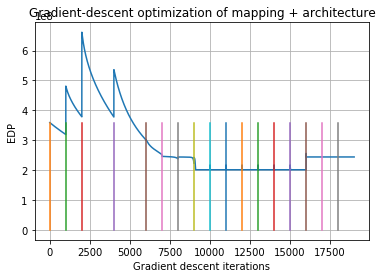

In [598]:
import math
import matplotlib.pyplot as plt
import numpy as np

net = ArchMap_spGEMM(2*3*2, 5*3, 5*7)

optimizer = optim.Adam(net.parameters() , lr=0.00005)

T = torch.tensor([1.0])

edp_list = []
edp_pen_list = []
cooling_points = []
temperature_list = []

thresh_pct = 0.5

edp = 0.0

pct = 100.0

i = 0

net(T)

while(T.item() > 1.0e-05):
    cooling_points.append(i)
    temperature_list.append(T.item())
    
    print("Temperature: ", T.item())
    print("Map: ", net.calcMap(T))
    print("Arch details:")
    net.archMapStats()
    print("-----------------------")
    pct = 100.0
    
    j = i
    while((pct > 10.0) and T.item() > 1.0e-05 and (i-j)<100000):
        optimizer.zero_grad() # clear gradients
        edp_pen = net(T) # forward step
        edp = net.problem_edp
        edp_pen_list.append(edp_pen.item())
        edp_list.append(edp.item())
        loss = edp_pen
        loss.backward() # backprop
        optimizer.step() # optimize weights
        if i % 1000 == 0:
            pct = 100.0
            if i > 0:
                pct = 100.0*abs(edp_list[-1]-edp_list[-500])/edp_list[-500] #100.0*abs(edp_list[-1]-edp_list[-2])/edp_list[-2]
            print("EDP: ", edp_list[-1], "EDP (penalized): ",  edp_pen_list[-1], " % decrease: ", pct)    
            

        
        
        i = i + 1
    print("Percentage threshold reached")
    T = T/2.0

fig = plt.figure()
plt.plot(edp_list)
plt.xlabel("Gradient descent iterations")
plt.ylabel("EDP")
plt.title("Gradient-descent optimization of mapping + architecture")
plt.grid("on")

for jdx in range(len(cooling_points)):
    plt.plot(np.array([cooling_points[jdx],cooling_points[jdx]]), np.array([-10.0,edp_list[0]]))
# len(edp_list)<2 or 100.0*math.abs(edp_list[-1]-edp_list[-2])/edp_list[-2] > thresh_pct

print("EDP: ", net(T), " Map: ", net.calcMap(T))

In [ ]:
gca.set_ylim([25, 50])

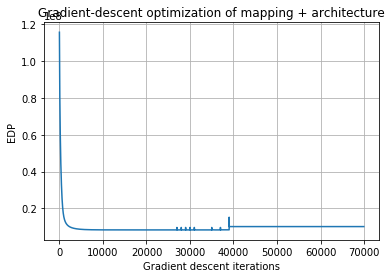

In [478]:
fig = plt.figure()
plt.plot(edp_list)
plt.xlabel("Gradient descent iterations")
plt.ylabel("EDP")
plt.title("Gradient-descent optimization of mapping + architecture")
plt.grid("on")

In [479]:
net(T)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(10119563., grad_fn=<MulBackward0>)

In [480]:
net.calcMap(T)

tensor([ 6.,  1.,  1., 25.,  1.,  1., 21.,  1.,  1.,  1.,  1.,  1.],
       grad_fn=<CatBackward>)

In [453]:
T = torch.tensor([1.0])
print("Temperature: ", T.item())
print("-----------------------")
print(net(T))
for i in range(20000):
    optimizer.zero_grad() # clear gradients
    edp = net(T) # forward step
    loss = edp
    loss.backward() # backprop
    optimizer.step() # optimize weights
    if i % 1000 == 0:
        print(net(T))
print("-----")
print("Final EDP: ", net(T))
print("Final map: ", net.calcMap(T))

Temperature:  1.0
-----------------------
tensor(1.4132e+08, grad_fn=<MulBackward0>)
tensor(1.4044e+08, grad_fn=<MulBackward0>)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(16999984., grad_fn=<MulBackward0>)
tensor(11566562., grad_fn=<MulBackward0>)
tensor(9905352., grad_fn=<MulBackward0>)
tensor(9195953., grad_fn=<MulBackward0>)
tensor(8873597., grad_fn=<MulBackward0>)
tensor(8706566., grad_fn=<MulBackward0>)
tensor(8613530., grad_fn=<MulBackward0>)
tensor(8559025., grad_fn=<MulBackward0>)
tensor(8526076., grad_fn=<MulBackward0>)
tensor(8505949., grad_fn=<MulBackward0>)
tensor(8493617., grad_fn=<MulBackward0>)
tensor(8486057., grad_fn=<MulBackward0>)
tensor(8481417., grad_fn=<MulBackward0>)
tensor(8478573., grad_fn=<MulBackward0>)
tensor(8476829., grad_fn=<MulBackward0>)
tensor(8475757., grad_fn=<MulBackward0>)
tensor(8475103., grad_fn=<MulBackward0>)
tensor(8474698., grad_fn=<MulBackward0>)
tensor(8474454., grad_fn=<MulBackward0>)
-----
Final EDP:  tensor(8474303., grad_fn=<MulBackward0>)
Final map:  tensor([ 5.7557,  1.0000,  1.1221, 19.6578,  1.0000,  2.4532, 18.6267,  1.4193,
         1.3717,  1.4193,  1.0000,  1.0000], grad_fn=<CatBackward>)


In [452]:
print("Final map: ", net.calcMap(T))

Final map:  tensor([1.7869, 3.3463, 1.5824, 5.2726, 3.2067, 6.5668, 5.0695, 6.7205, 2.4300,
        2.7369, 1.3967, 2.1636], grad_fn=<CatBackward>)


In [455]:
T = torch.tensor([0.1])
print("Temperature: ", T.item())
print("-----------------------")
print(net(T))
for i in range(20000):
    optimizer.zero_grad() # clear gradients
    edp = net(T) # forward step
    loss = edp
    loss.backward() # backprop
    optimizer.step() # optimize weights
    if i % 1000 == 0:
        print(net(T))
print("-----")
print("Final EDP: ", net(T))
print("Final map: ", net.calcMap(T))

Temperature:  0.10000000149011612
-----------------------
tensor(8512693., grad_fn=<MulBackward0>)
tensor(8512693., grad_fn=<MulBackward0>)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(8512692., grad_fn=<MulBackward0>)
tensor(8512693., grad_fn=<MulBackward0>)
tensor(8474068., grad_fn=<MulBackward0>)
tensor(8474070., grad_fn=<MulBackward0>)
tensor(8474067., grad_fn=<MulBackward0>)
tensor(8474067., grad_fn=<MulBackward0>)
tensor(8474068., grad_fn=<MulBackward0>)
tensor(8474066., grad_fn=<MulBackward0>)
tensor(8474067., grad_fn=<MulBackward0>)
tensor(8474066., grad_fn=<MulBackward0>)
tensor(8474065., grad_fn=<MulBackward0>)
tensor(8474066., grad_fn=<MulBackward0>)
tensor(8474065., grad_fn=<MulBackward0>)
tensor(8474065., grad_fn=<MulBackward0>)
tensor(8474068., grad_fn=<MulBackward0>)
tensor(8474066., grad_fn=<MulBackward0>)
tensor(8474066., grad_fn=<MulBackward0>)
tensor(8474065., grad_fn=<MulBackward0>)
tensor(8474067., grad_fn=<MulBackward0>)
-----
Final EDP:  tensor(8474069., grad_fn=<MulBackward0>)
Final map:  tensor([ 5.7559,  1.0000,  1.1221, 19.6561,  1.0000,  2.4539, 18.6278,  1.4192,
         1.3716,  1.4192,  1.0000,  1.0000], grad_fn=<CatBackward>)


In [457]:
T = torch.tensor([0.001])
print("Temperature: ", T.item())
print("-----------------------")
print(net(T))
for i in range(10000):
    optimizer.zero_grad() # clear gradients
    edp = net(T) # forward step
    loss = edp
    loss.backward() # backprop
    optimizer.step() # optimize weights
    if i % 1000 == 0:
        print(net(T))
print("-----")
print("Final EDP: ", net(T))
print("Final map: ", net.calcMap(T))

Temperature:  0.0010000000474974513
-----------------------
tensor(10119563., grad_fn=<MulBackward0>)
tensor(10119563., grad_fn=<MulBackward0>)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(10119563., grad_fn=<MulBackward0>)
tensor(10119563., grad_fn=<MulBackward0>)
tensor(10119563., grad_fn=<MulBackward0>)
tensor(10119563., grad_fn=<MulBackward0>)
tensor(10119563., grad_fn=<MulBackward0>)
tensor(10119563., grad_fn=<MulBackward0>)
tensor(10119563., grad_fn=<MulBackward0>)
tensor(10119563., grad_fn=<MulBackward0>)
tensor(10119563., grad_fn=<MulBackward0>)
-----
Final EDP:  tensor(10119563., grad_fn=<MulBackward0>)
Final map:  tensor([ 6.,  1.,  1., 25.,  1.,  1., 21.,  1.,  1.,  1.,  1.,  1.],
       grad_fn=<CatBackward>)


In [429]:
print("Temperature: ", T.item())
print("-----------------------")
print(net(T))
for i in range(10000):
    optimizer.zero_grad() # clear gradients
    edp = net(T) # forward step
    loss = edp
    loss.backward() # backprop
    optimizer.step() # optimize weights
    if i % 1000 == 0:
        print(net(T))
print("-----")
print("Final EDP: ", net(T))

Temperature:  0.009999999776482582
-----------------------
tensor(9359604., grad_fn=<MulBackward0>)
tensor(9359609., grad_fn=<MulBackward0>)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(9359602., grad_fn=<MulBackward0>)
tensor(9359610., grad_fn=<MulBackward0>)
tensor(9359603., grad_fn=<MulBackward0>)
tensor(9359601., grad_fn=<MulBackward0>)
tensor(9359624., grad_fn=<MulBackward0>)
tensor(9359604., grad_fn=<MulBackward0>)
tensor(9359759., grad_fn=<MulBackward0>)
tensor(9359612., grad_fn=<MulBackward0>)
tensor(9048232., grad_fn=<MulBackward0>)
-----
Final EDP:  tensor(9048230., grad_fn=<MulBackward0>)
